<a href="https://colab.research.google.com/github/ROARMarketingConcepts/Data-Projects/blob/master/Energy_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### In this analysis, we take the PJM energy load data downloaded from Kaggle.com and take look at some statistics relative to energy consumption.

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import time
import datetime

import matplotlib.pyplot as plt
from matplotlib import interactive
plt.rc("font", size=14)
from pylab import scatter, show, legend, xlabel, ylabel

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Energy Consumption Data Analysis/hourly-energy-consumption/pjm_hourly_est.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178262 entries, 0 to 178261
Data columns (total 13 columns):
Datetime    178262 non-null object
AEP         121273 non-null float64
COMED       66497 non-null float64
DAYTON      121275 non-null float64
DEOK        57739 non-null float64
DOM         116189 non-null float64
DUQ         119068 non-null float64
EKPC        45334 non-null float64
FE          62874 non-null float64
NI          58450 non-null float64
PJME        145366 non-null float64
PJMW        143206 non-null float64
PJM_Load    32896 non-null float64
dtypes: float64(12), object(1)
memory usage: 17.7+ MB


In [0]:
df.head()

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


### Let's convert all the 'NaN' fields to zeroes...

In [0]:
df = df.fillna(0.0, axis=1)

### The date and time in the 'Datetime' column is a string object variable.  We need to convert it to a datetime variable and then extract all the time and date data.

In [0]:
import calendar
import datetime as dt

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Date'] = df['Datetime'].dt.date
df['Year'] = df['Datetime'].dt.year

df['Month'] = df['Datetime'].dt.month
# df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])    # Get month name from month index

df['Day'] = df['Datetime'].dt.day

df['Weekday'] = df['Datetime'].dt.dayofweek
# df['Weekday'] = df['Datetime'].apply(lambda x: dt.datetime.strftime(x, '%A'))  # Get day of week name from dayofweek index

df['Hour'] = df['Datetime'].dt.hour

In [0]:
df['Weekday'].head()

0    3
1    3
2    3
3    3
4    3
Name: Weekday, dtype: int64

We have 20 years of data...but many values for PJM_Load are either missing or equal to zero.

In [0]:
df['Year'].unique()

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

Let's find and keep the rows where PJM_Load $\neq$ 0   This reduces the dataset from 178262 rows to 32896 rows.

In [0]:
df = df[df.PJM_Load != 0.0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32896 entries, 0 to 32895
Data columns (total 19 columns):
Datetime    32896 non-null datetime64[ns]
AEP         32896 non-null float64
COMED       32896 non-null float64
DAYTON      32896 non-null float64
DEOK        32896 non-null float64
DOM         32896 non-null float64
DUQ         32896 non-null float64
EKPC        32896 non-null float64
FE          32896 non-null float64
NI          32896 non-null float64
PJME        32896 non-null float64
PJMW        32896 non-null float64
PJM_Load    32896 non-null float64
Date        32896 non-null object
Year        32896 non-null int64
Month       32896 non-null int64
Day         32896 non-null int64
Weekday     32896 non-null int64
Hour        32896 non-null int64
dtypes: datetime64[ns](1), float64(12), int64(5), object(1)
memory usage: 5.0+ MB


Calculate the load by month per year...

In [0]:
monthly_load_per_year = df.groupby(['Year','Month'])['PJM_Load'].sum().reset_index()
monthly_load_per_year

,Year,Month,PJM_Load
0,1998,4,18258202.0
1,1998,5,19914613.0
2,1998,6,21413823.0
3,1998,7,24449999.0
4,1998,8,24685281.0
5,1998,9,21446221.0
6,1998,10,19094647.0
7,1998,11,19145916.0
8,1998,12,21333067.0
9,1999,1,22901603.0


### Let's plot this data as a bar chart...

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


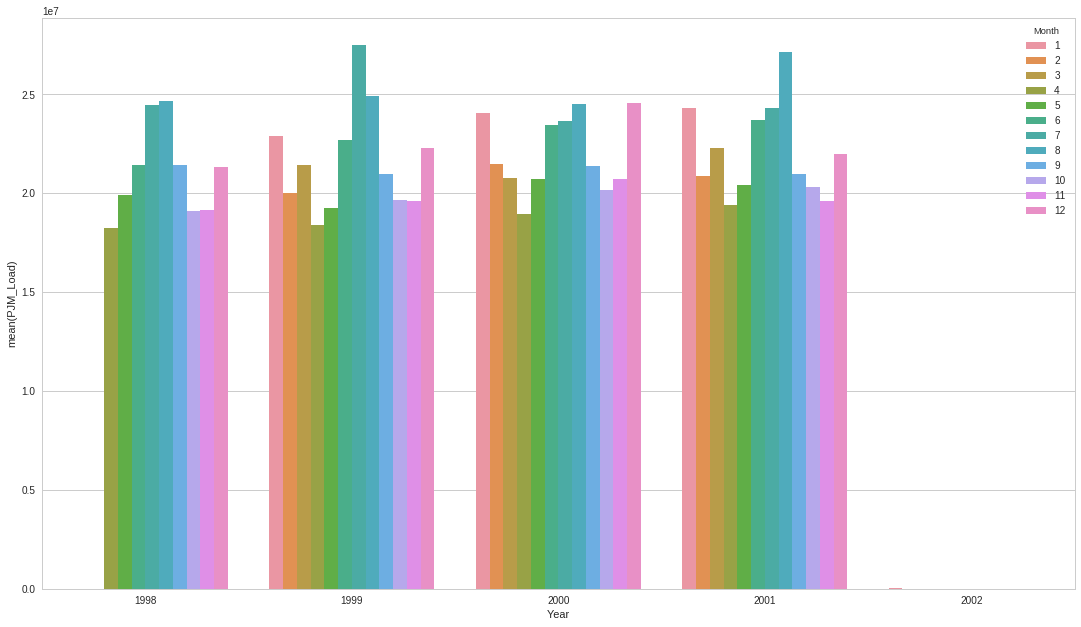

In [0]:
import seaborn as sns; sns.set()
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = sns.barplot(x="Year", y="PJM_Load", hue="Month", data=monthly_load_per_year)

In [0]:
weekday_load = df.groupby(['Weekday'])['PJM_Load'].sum().reset_index()
weekday_load

,Weekday,PJM_Load
0,0,143619271.0
1,1,145611414.0
2,2,145992447.0
3,3,144961111.0
4,4,143108442.0
5,5,130270196.0
6,6,125633515.0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


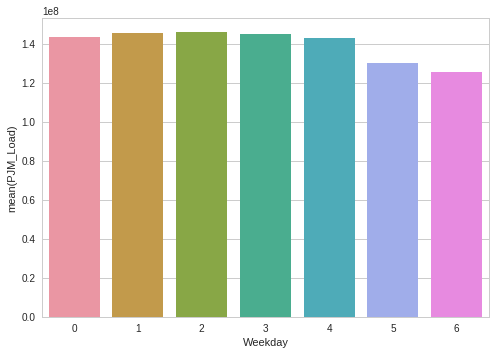

In [0]:
ax = sns.barplot(x="Weekday", y="PJM_Load", data=weekday_load)

In [0]:
hourly_load = df.groupby(['Hour'])['PJM_Load'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


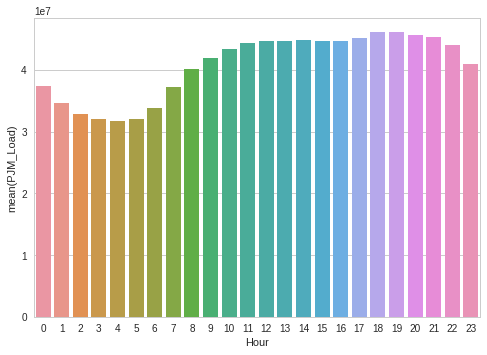

In [0]:
ax = sns.barplot(x="Hour", y="PJM_Load", data=hourly_load)

In [0]:
monthly_load = df.groupby(['Month'])['PJM_Load'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


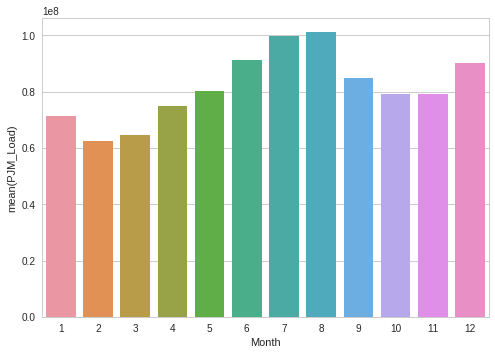

In [0]:
ax = sns.barplot(x="Month", y="PJM_Load", data=monthly_load)